In [1]:
import miner_py3 as miner
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import time

## Create directory to save output files

In [2]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# Path to the scenic directory
scenic_path = os.path.join(os.path.expanduser('~'),'Desktop','scenic','results')

# create name for results folder where output files will be saved
resultsFolder = "benchmark_results"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [9]:
# # Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

#Load results of MINER mechanistic inference
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load results of SCENIC mechanistic inference
scenic_regulonModules = miner.read_pkl(os.path.join(scenic_path,"old_regulons.p"))
scenic_regulonDf = miner.scenic_regulons_to_df(scenic_regulonModules)
scenic_regulon_activity = pd.read_csv(os.path.join(scenic_path,"old_binary_regulon_matrix.csv"),index_col=0,header=0)
scenic_eigengenes = pd.read_csv(os.path.join(scenic_path,"old_auc_matrix.csv"),index_col=0,header=0).T

#Load table for converting gene names
id_table_path = os.path.join(os.path.expanduser("~"),"Desktop","GitHub","miner","miner","data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

completed identifier conversion.
16216 genes were converted.


In [10]:
scenic_eigengenes.head()

Cell,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
AHRR(+),0.061541,0.000000,0.000000,0.000000,0.000000,0.093444,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031956,0.000000,0.000000,0.000000,0.000000,0.015184,0.000000,0.061523
ALX4(+),0.000000,0.000000,0.000000,0.000000,0.006598,0.040931,0.010131,0.000000,0.000000,0.000000,...,0.003426,0.000000,0.000000,0.000000,0.000000,0.000000,0.068148,0.016231,0.000000,0.000000
AR(+),0.000000,0.036325,0.000000,0.000000,0.022857,0.000000,0.000000,0.063129,0.024591,0.021566,...,0.047187,0.038079,0.061063,0.019765,0.014635,0.000000,0.019800,0.052401,0.000000,0.000000
ARID3A(+),0.016297,0.060500,0.004376,0.052027,0.009536,0.049190,0.044534,0.026453,0.005516,0.031694,...,0.040293,0.024486,0.040797,0.012904,0.004443,0.021043,0.127499,0.033145,0.029076,0.040338
ARID5B(+),0.007889,0.043757,0.065091,0.004724,0.004889,0.000387,0.003843,0.014276,0.017560,0.010967,...,0.025282,0.007756,0.022071,0.013253,0.013347,0.023260,0.007800,0.052268,0.039815,0.020176


In [11]:
eigengenes.head()

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
0,0.178740,0.011642,-1.277219,1.247632,-0.585609,0.261393,0.596338,-0.067393,-0.650201,0.238947,...,0.835363,0.723893,-0.786396,0.706913,-0.335762,0.251454,0.889138,0.306508,-0.602823,0.437464
1,0.866678,0.724814,-0.393543,0.101917,0.344166,-0.453006,0.023749,-0.326654,0.094599,-0.855732,...,-0.441954,-0.500115,1.165609,-1.836226,1.672109,-0.490311,0.260839,1.396989,0.873376,-1.287597
2,-0.422522,1.799548,1.706533,-0.373626,0.887450,0.009927,0.286414,0.630014,1.758979,-1.212926,...,0.258732,-0.950024,1.623291,-1.402383,-0.466052,-0.931944,-0.265786,-0.426570,0.640741,-0.591689
3,-0.591786,-0.632538,-0.609258,-0.614289,0.827146,-0.608319,0.734981,-0.484512,-0.844285,0.753774,...,1.513613,-0.816606,-0.693199,-0.775639,-0.609276,-0.719568,-0.860545,1.855164,0.791384,-0.701320
4,-1.147901,0.720301,1.517289,-0.815249,0.009879,-0.684793,-0.459015,0.283762,1.014416,-0.341275,...,-0.518122,-0.398661,1.342812,-1.209550,0.201257,-0.640614,-0.949438,-0.267505,0.450936,0.184355


In [12]:
gene_expression_sample_distances = miner.pairwise_distance(expressionData)
miner_regulon_sample_distances = miner.pairwise_distance(eigengenes)
scenic_regulon_sample_distances = miner.pairwise_distance(scenic_eigengenes)

In [13]:
miner_spearman_rs = []
scenic_spearman_rs = []
for i in range(gene_expression_sample_distances.shape[0]):
    #rank correlate scenic pairwise distances to expression distances
    scenic_r, scenic_p = stats.spearmanr(gene_expression_sample_distances.iloc[i,:],
                   scenic_regulon_sample_distances.iloc[i,:])
    scenic_spearman_rs.append(scenic_r)
    
    #rank correlate miner pairwise distances to expression distances
    miner_r, miner_p = stats.spearmanr(gene_expression_sample_distances.iloc[i,:],
                   miner_regulon_sample_distances.iloc[i,:])
    miner_spearman_rs.append(miner_r)

Text(0.5, 0, 'Spearman Rho')

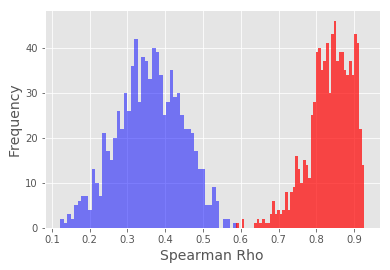

In [14]:
_=plt.hist(scenic_spearman_rs,bins=50,color="blue",alpha=0.5)
_=plt.hist(miner_spearman_rs,bins=50,color="red",alpha=0.7)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Spearman Rho",FontSize=14)

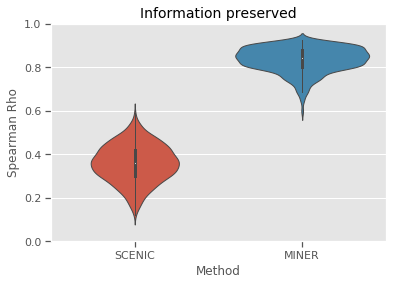

In [16]:
#Format results for seaborn
spearman_results = np.hstack([scenic_spearman_rs,miner_spearman_rs])
spearman_labels = np.hstack([["SCENIC" for i in range(len(scenic_spearman_rs))],
                            ["MINER" for i in range(len(miner_spearman_rs))]])
spearman_results_df = pd.DataFrame(np.vstack([spearman_results,spearman_labels]).T)
spearman_results_df.columns = ["Spearman Rho","Method"]
spearman_results_df = spearman_results_df.astype({"Spearman Rho": float, "Method": str})

#Plot spearman results
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})
ax = sns.violinplot(x="Method", y="Spearman Rho", data=spearman_results_df)
ax.set(ylim=(0, 1))
ax.set_title("Information preserved",fontsize=14)
plt.savefig(os.path.join(resultsDirectory,"Information_preserved_miner_scenic.pdf"),bbox_inches="tight")

In [17]:
#Use Wilcoxon rank-sum test to compare distributions
w, p = stats.ranksums(scenic_spearman_rs,miner_spearman_rs)
print(p)

3.5105063237020305e-289


In [23]:
print('SCENIC spearman rho distribution: {:.2f} +/- {:.2f}.\nMINER spearman rho distribution: {:.2f} +/- {:.2f}.'.format(np.mean(scenic_spearman_rs),np.std(scenic_spearman_rs),np.mean(miner_spearman_rs),np.std(miner_spearman_rs)))


SCENIC spearman rho distribution: 0.36 +/- 0.09.
MINER spearman rho distribution: 0.84 +/- 0.06.


## Regulon quality assessment

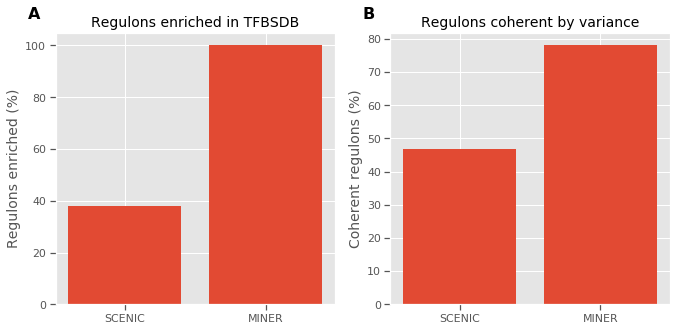

In [18]:
#Load regulon quality assessment results
regulons_enriched_df = pd.read_csv(os.path.join(scenic_path,"TFBSDB_enrichment_pct.csv"),index_col=0)
regulons_coherent_df = pd.read_csv(os.path.join(scenic_path,"Regulon_coherence.csv"),index_col=0)

#Instantiate figure
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(11)

#Regulon enrichment
ax1.bar(["SCENIC","MINER"],[regulons_enriched_df.loc["SCENIC","TFBSDB_enrichment_pct"],
                            regulons_enriched_df.loc["MINER","TFBSDB_enrichment_pct"]])
ax1.set_title("Regulons enriched in TFBSDB",FontSize=14)
ax1.set_ylabel("Regulons enriched (%)",FontSize=14)

#Regulon coherence
ax2.bar(["SCENIC","MINER"],[regulons_coherent_df.loc["SCENIC","Regulon_coherence"],
                            regulons_coherent_df.loc["MINER","Regulon_coherence"]])
#ax2.bar(["SCENIC","MINER"],[MMRF_percent_significant_p_0o05_scenic,MMRF_percent_significant_p_0o05])
ax2.set_title("Regulons coherent by variance",FontSize=14)
ax2.set_ylabel("Coherent regulons (%)",FontSize=14)

#Add letters
import string
axs = [ax1,ax2]
for n, ax in enumerate(axs):  
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')
#Save figure
plt.savefig(os.path.join(resultsDirectory,"new_regulon_comparison_barplot.pdf"),bbox_inches="tight")

## Summary figure

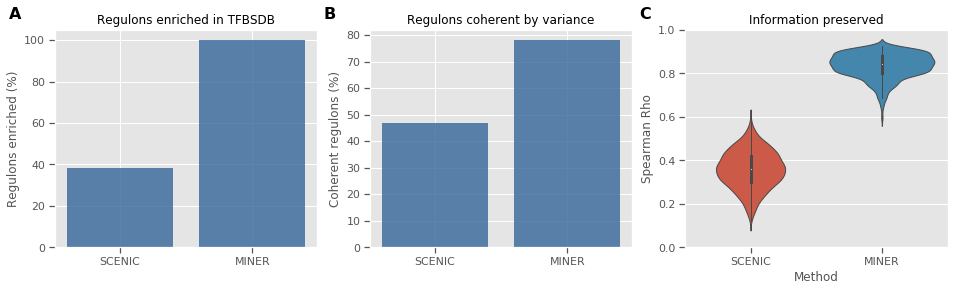

In [19]:
#Instantiate figure
f, (ax1, ax2,ax3) = plt.subplots(1,3)
f.set_figheight(4)
f.set_figwidth(16)

#Regulon enrichment
ax1.bar(["SCENIC","MINER"],[regulons_enriched_df.loc["SCENIC","TFBSDB_enrichment_pct"],
                            regulons_enriched_df.loc["MINER","TFBSDB_enrichment_pct"]],
       color=[0.2,0.4,0.6],alpha=0.8)
ax1.set_title("Regulons enriched in TFBSDB",FontSize=12)
ax1.set_ylabel("Regulons enriched (%)",FontSize=12)

#Regulon coherence
ax2.bar(["SCENIC","MINER"],[regulons_coherent_df.loc["SCENIC","Regulon_coherence"],
                            regulons_coherent_df.loc["MINER","Regulon_coherence"]],
       color=[0.2,0.4,0.6],alpha=0.8)
#ax2.bar(["SCENIC","MINER"],[MMRF_percent_significant_p_0o05_scenic,MMRF_percent_significant_p_0o05])
ax2.set_title("Regulons coherent by variance",FontSize=12)
ax2.set_ylabel("Coherent regulons (%)",FontSize=12)

#Information preserved
plt.sca(ax3)
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})
ax = sns.violinplot(x="Method", y="Spearman Rho", data=spearman_results_df)
ax.set(ylim=(0, 1))
ax.set_title("Information preserved",fontsize=12)

#Add letters
import string
axs = [ax1,ax2,ax3]
for n, ax in enumerate(axs):  
    ax.text(-0.175, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')
#Save figure
plt.savefig(os.path.join(resultsDirectory,"benchmark_miner_mechanistic_inference.png"),
            dpi=400,
            bbox_inches="tight")

## Risk benchmarking

In [122]:
# Path to the scenic directory
scenic_path = os.path.join(os.path.expanduser('~'),'Desktop','scenic','results')

#Read clusters identified by differential expression + STRING analysis
ppi_clusters = pd.read_csv(os.path.join(scenic_path,'MINER','string_MCL_clusters.tsv'),sep='\t')
# Cluster 1
ppi_cluster_1 = list(ppi_clusters[ppi_clusters["cluster number"]==1]["protein name"])
ppi_cluster_1_ens = miner.gene_conversion(ppi_cluster_1,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)
# Cluster 2
ppi_cluster_2 = list(ppi_clusters[ppi_clusters["cluster number"]==2]["protein name"])
ppi_cluster_2_ens = miner.gene_conversion(ppi_cluster_2,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)
# Cluster 3
ppi_cluster_3 = list(ppi_clusters[ppi_clusters["cluster number"]==3]["protein name"])
ppi_cluster_3_ens = miner.gene_conversion(ppi_cluster_3,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)

#Format as dictionary
ppi_cluster_dict = {1:ppi_cluster_1_ens,
                   2:ppi_cluster_2_ens,
                   3:ppi_cluster_3_ens}

# Get eigengenes for all modules
eigengenes_ppi = miner.getEigengenes(ppi_cluster_dict,expressionData,regulon_dict=None,saveFolder=None)
eigenScale_ppi = np.percentile(expressionData,95)/np.percentile(eigengenes_ppi,95)
eigengenes_ppi = eigenScale_ppi*eigengenes_ppi
eigengenes_ppi.index = np.array(eigengenes_ppi.index).astype(int)

#Format pathway enrichments for survival analysis
input_df = pd.DataFrame(eigengenes_ppi.loc[1,:].T)
input_df = input_df.loc[guanSurvivalDfMMRF.index,:]

#Perform Cox Hazards regression
tmp_surv_results = miner.survivalMedianAnalysisDirect(input_df,guanSurvivalDfMMRF.copy())
tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
tmp_surv_df.columns = ["HR","p"]
tmp_surv_df.index = [term]
print(tmp_surv_df)

In [124]:
# Get eigengenes for all modules
eigengenes_ppi = miner.getEigengenes(ppi_cluster_dict,expressionData,regulon_dict=None,saveFolder=None)
eigenScale_ppi = np.percentile(expressionData,95)/np.percentile(eigengenes_ppi,95)
eigengenes_ppi = eigenScale_ppi*eigengenes_ppi
eigengenes_ppi.index = np.array(eigengenes_ppi.index).astype(int)

In [125]:
eigengenes_ppi

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
1,-0.007897,0.360880,0.546628,-0.154096,-0.660801,0.660874,2.376540,-0.593265,1.798599,-0.111248,...,-0.062625,0.032436,-0.028191,0.861492,0.311381,0.810449,-0.690851,-0.011289,-0.986775,-0.265223
2,-1.216581,-0.354228,-0.197810,0.231654,-0.553502,-0.254813,-0.960487,0.227316,-0.588700,0.604602,...,-1.301411,-0.137225,0.613297,-0.917145,-0.646178,-0.567710,-0.158795,0.118700,1.117029,-0.481136
3,0.227880,-1.090522,1.107503,-1.090522,-1.090522,0.808066,1.705304,1.162120,1.761661,0.903667,...,0.277864,0.179583,-0.033756,0.781921,0.815723,0.309116,-0.857253,0.361188,-0.873846,-0.412580
